In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from itertools import groupby
from collections import Counter
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_pickle("../data/connected_sources/2016")

In [3]:
df.head()

,#DBpURL,ID,WikiURL,birthDate,deathDate,first_name,full_name,gender,name,nationality,...,party,entered,efficiency,eig_central,id,in_degree,k_core,out_degree,name_u,views
0,http://dbpedia.org/resource/Nizamettin_Erkmen,144,http://en.wikipedia.org/wiki/Nizamettin_Erkmen,None,1990-10-24 00:00:00,nizamettin,Nizamettin+Erkmen,male,[ erkmen nizamettin ],[turkish],...,[],2007,0.760000,0.000046,144,2,4,3,Nizamettin_Erkmen,916.0
1,http://dbpedia.org/resource/Claudio_Scajola,183,http://en.wikipedia.org/wiki/Claudio_Scajola,1948-01-15 00:00:00,None,claudio,Claudio+Scajola,male,[ claudio scajola ],[italian],...,[ forza italia (2013) ],2005,0.899654,0.000801,183,9,10,8,Claudio_Scajola,4100.0
2,http://dbpedia.org/resource/Thomas_Clausen_(Lo...,246,http://en.wikipedia.org/wiki/Thomas_Clausen_(L...,1939-12-22 00:00:00,2002-02-20 00:00:00,thomas,Thomas+Clausen+(Louisiana),male,"[ thomas greenwood clausen , clausen thomas g...",[american],...,[ democratic party (united states) ],2013,0.734694,0.000040,246,2,7,5,Thomas_Clausen_(Louisiana),1651.0
3,http://dbpedia.org/resource/Yang_Ti-liang,248,http://en.wikipedia.org/wiki/Yang_Ti-liang,1929-06-30 00:00:00,None,yang,Yang+Ti-liang,male,[ ti-liang yang ],[],...,[],2007,1.000000,0.000007,248,2,5,4,Yang_Ti-liang,6671.0
4,http://dbpedia.org/resource/Mohammad_Natsir,259,http://en.wikipedia.org/wiki/Mohammad_Natsir,1908-07-17 00:00:00,1993-03-14 00:00:00,mohammad,Mohammad+Natsir,male,"[ mohammad natsir , natsir mohammad ]",[indonesian],...,[ masyumi party ],2007,0.814815,0.000068,259,4,4,5,Mohammad_Natsir,7825.0


In [4]:
def drop_columns(df, lst):
    """ Removes dataframe columns specified in lst
    """
    df = df.drop(lst, axis=1)
    return df 

In [5]:
# def get_age(x, thres=110):
#     """ Calculates age of politicians, if birth unknown age is by default=0
#     """
#     birth = x["birthDate"]
#     death = x["deathDate"]
#     if birth == None:
#         return 0 # we don't know age of birt
#     if death == None:
#         delta = datetime.now() - birth
#         age = int(delta.days/365)
#         if age < thres and age > 17.5:
#             return age
#         return -1 # we are not sure when and if the person died 
#     elif death != None and birth!= None:
#         delta = death - birth
#         if death < birth:
# #             age = abs(int(delta.days/365))
# #             if age < thres:
# #                 return age
# #             else:
#             return -1 # we are not sure when and if the person died
#         age = abs(int(delta.days/365))
#         if age < thres and age > 17.5:
#             return int(delta.days/365)
#         else:
#             return -1

In [6]:
def get_age(x, thres=110):
    """ Calculates age of politicians, if birth unknown age is by default=0
    """
    birth = x["birthDate"]
    death = x["deathDate"]
    
    if birth == None and death == None:
        return 0
    if birth != None and death == None:
        delta = datetime.now() - birth
        age = int(delta.days/365)
        if age < 18:
            return 0
        if age < thres:
            return age
        else:
            return 0
    if birth != None and death != None:
        # it might happen that death is before birth.. 
        delta = death - birth
        if death < birth:
            return -1
        else: 
            age = abs(int(delta.days/365))    
            if age < thres and age >= 18:
                return int(delta.days/365)
            else:
                return 0
    if birth == None and death != None:
        return 0 

In [7]:
def is_alive(x, thres=110):
    """ Returns yes / no / unknown depending on if the politician is alive/dead
    """
    birth = x["birthDate"]
    death = x["deathDate"]
    age = x["age"]
    
    if birth != None and death != None:
        if age != -1:
            return "no"
        else:
            return "unknown"        
    if birth == None and death != None:
        return "no"
    if birth != None and death == None:
        if age > 0:
            return "yes"
        elif age == 0 and int((datetime.now() - birth).days/365) < thres:
            return "unknown"
        elif age == 0 and int((datetime.now() - birth).days/365) >= thres:
            return "no"
    if birth == None and death == None:
        return "unknown"
#     if birth != None and death != None:
#         if age != -1:
#             return "no"
#         else:
#             return "unknown"
#     if age == -1 and int((datetime.now() - birth).days/365) < 110:
#         return "unknown"
#     elif age == -1 and int((datetime.now() - birth).days/365) > 110:
#         return "no"
#     elif death != None:
#         return "no"
#     elif death == None and birth == None:
#         return "unknown"
#     elif age > 0:
#         return "yes"
        
        

In [8]:
def add_age(df):
    """ Adds age column to dataframe
    """
    df["age"] = df.apply(lambda x: get_age(x), axis=1)
    return df

In [9]:
def add_alive_status(df):
    df["is_alive"] = df.apply(lambda x: is_alive(x), axis=1)
    return df

In [10]:
def age_distance(date):
    """ Calculates distance from given date to present, if the distance is negative
    it results as a default value -1 
    """
#     print(date)
    if date == None:
        return -1
    else:
        delta = datetime.now() - date
        distance = int(delta.days/365)
        if distance > 0:
            return int(delta.days/365)
        else:
            return -1

In [11]:
def add_distance(df):
    """ Adds 2 columns ["distance_birth"] and ["distance_death"] 
    """
#     if birth_death == "birth":
    df["distance_birth"] = df.apply(lambda x: age_distance(x["birthDate"]),axis=1)
#     elif birth_death == "death":
    df["distance_death"] = df.apply(lambda x: age_distance(x["deathDate"]),axis=1)
    return df

In [12]:
def delta_birth_death(x):
    birth = x["distance_birth"]
    death = x["distance_death"]
    return birth - death

In [13]:
def add_delta(df):
    df["distance_delta"] = df.apply(lambda x: delta_birth_death(x), axis=1)
    return df

In [14]:
def add_lst_size(df,col):
    df[col+"_num"] = df[col].apply(lambda x: len(x))
    return df 

# Exploration of variables

In [15]:
def get_bar_categorical(column_name, title="Politician nationality values distribution", dir_save="../plots/variables"):
    SMALL_SIZE = 26
    MEDIUM_SIZE = 30
    BIGGER_SIZE = 40

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)
#     plt.rc("title", titlesize = BIGGER_SIZE)
    num = sorted([len(i) for i in df[column_name].values.flatten()])
    num = [len(list(group)) for key, group in groupby(num)]
    print(num)
    label = range(0, len(num))
    plt.figure(figsize=(15,10))
    plt.bar(label, num)
    plt.xlabel("Number of {} values".format(column_name))
    plt.xticks(np.arange(min(label), max(label)+1, 1.0))
    plt.ylabel("Frequency")
    plt.title(title)
    path_save = dir_save+"/"+column_name+".jpg"
    plt.savefig(path_save)
    plt.show()

In [16]:
def get_unique_values_multilevel_categorical(df, column_name):
    flat = [i for i in df[column_name].values if len(i)>0]
    flat = sum(flat, [])
    keys = Counter(flat).keys()
    return keys, len(keys)

In [17]:
def get_most_frequent(df, column_name, n):
    flat = [i for i in df[column_name].values if len(i)>0]
    flat = sum(flat, [])
    c = Counter(flat)
    if column_name == "occupation":
        return c.most_common(n+1)[1:]
    return pd.DataFrame(c.most_common(n))

In [18]:
def get_counts(df, column_name, reverse=True):
    flat = [i for i in df[column_name].values if len(i)>0]
    flat = sum(flat, [])
    return sorted(Counter(flat).values(), reverse=reverse)

In [19]:
def get_percentiles(df, col, percentile = [.95]):
    counts = get_counts(df, col, reverse=False)
    c = pd.DataFrame(counts)
#     print(c)
    c.columns = ["count"]
    if col == "occupation":
        c = c[c["count"] != c["count"].max()]
#     c["cumulative"] = c.cumsum()
    return c["count"].describe(percentiles = percentile)

In [20]:
def plot_correlation_map( df , annot=True):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = annot, 
        annot_kws = { 'fontsize' : 12 }
    )

In [21]:
lst = ["occupation", "party", "nationality"]
for col in lst:
    keys, num = get_unique_values_multilevel_categorical(df, col)
    print("{} has {} unique values".format(col,num))

occupation has 3020 unique values
party has 3661 unique values
nationality has 342 unique values


In [22]:
lst = ["occupation", "party", "nationality"]
for col in lst:
    print(get_most_frequent(df,col,30))

[('writer', 3188), ('scientist', 2164), ('journalist', 1357), ('economist', 779), ('lawyer', 721), ('historian', 599), ('sportsperson', 596), ('physician', 528), ('player', 404), ('actor', 384), ('novelist', 214), ('teacher', 166), ('businessperson', 157), ('business', 143), ('civil service', 137), ('diplomat', 131), ('footballer', 124), ('author', 108), ('actress', 103), ('activism', 95), ('professor', 86), ('politics', 68), ('mathematician', 65), ('coach', 64), ('judge', 64), ('poet', 63), ('farmer', 61), ('jurist', 54), ('physicist', 51), ('member of parliament', 49)]
                                          0     1
0         democratic party (united states)   3071
1         republican party (united states)   1767
2                   independent politician    737
3                 indian national congress    731
4                 communist party of china    444
5                   bharatiya janata party    334
6                        labour party (uk)    298
7                  lib

In [23]:
get_percentiles(df, "party")

count    3661.000000
mean        7.940727
std        63.680731
min         1.000000
50%         2.000000
95%        24.000000
max      3071.000000
Name: count, dtype: float64

In [24]:
get_percentiles(df, "occupation")

count    3019.000000
mean        6.164624
std        79.972562
min         1.000000
50%         1.000000
95%         7.000000
max      3188.000000
Name: count, dtype: float64

In [25]:
get_percentiles(df, "nationality")

count     342.000000
mean       92.666667
std       327.391047
min         1.000000
50%         9.000000
95%       434.500000
max      4788.000000
Name: count, dtype: float64

In [26]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_df = df.select_dtypes(include=numerics)
num_df.columns

Index(['ID', 'entered', 'efficiency', 'eig_central', 'id', 'in_degree',
       'k_core', 'out_degree', 'views'],
      dtype='object')

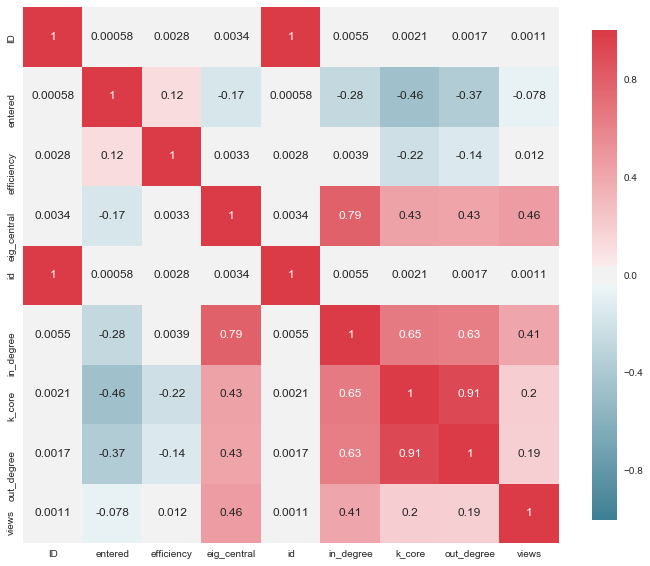

In [27]:
plot_correlation_map(num_df)

In [28]:
# get_bar_categorical("nationality")

In [29]:
# get_bar_categorical("party", title="Politician party values distribution")

In [30]:
# get_bar_categorical("occupation", title="Politician occupation values distribution") # 0 is for polititian 

# Filter by column value

In [31]:
def get_from_lst(lst,value):
    """ Returns value if in list, returns "none" if not
    """
#     print(lst)
    lst = [x.strip(" ") for x in lst]
    if value in lst:
#         print(value)
        return value
    else:
        return "none"
    
def filter_by_value(df, column, value):
    """ Returns dataframe after filtering colums per value 
    """
    df["filter_cols"] = df[column].apply(lambda x: get_from_lst(x, value))
    df = df[df["filter_cols"] == value]
    df = df.drop("filter_cols", axis=1)
    return df

In [32]:
# filter_by_value(df, "party", "liberal party of canada").head()

# Dumify 

In [33]:
def to_binary(lst,value):
#     lst = [x.strip(" ") for x in lst]
    if value in lst:
        return 1
    else:
        return 0
def other_to_bin(x, lst):
    sumed = 0
    for i in lst:
        sumed = sumed + x[i]
    if sumed > 0:
        return 0
    else:
        return 1 
    
def add_binary_column(df, column, column_new, value):
    """ Adds 1 or 0 to a new column, therefore biarising the  
    """
    df[column_new] = df[column].apply(lambda x: to_binary(x, value))
    return df

In [34]:
add_binary_column(df,"nationality", "us", "american").head()
add_binary_column(df,"nationality", "de", "german").head()
add_binary_column(df,"nationality", "fr", "french").head()
add_binary_column(df,"nationality", "in", "indian").head()
add_binary_column(df,"nationality", "cd", "canadian").head()
add_binary_column(df,"nationality", "no", "norwegian").head()
add_binary_column(df,"nationality", "ru", "russian").head()
add_binary_column(df,"nationality", "gb", "british").head()
df["other_n"] = df.apply(lambda x: other_to_bin(x, ["us","de","fr","in","cd","no","ru","gb"]), axis=1)

In [35]:
df

,#DBpURL,ID,WikiURL,birthDate,deathDate,first_name,full_name,gender,name,nationality,...,views,us,de,fr,in,cd,no,ru,gb,other_n
0,http://dbpedia.org/resource/Nizamettin_Erkmen,144,http://en.wikipedia.org/wiki/Nizamettin_Erkmen,None,1990-10-24 00:00:00,nizamettin,Nizamettin+Erkmen,male,[ erkmen nizamettin ],[turkish],...,916.0,0,0,0,0,0,0,0,0,1
1,http://dbpedia.org/resource/Claudio_Scajola,183,http://en.wikipedia.org/wiki/Claudio_Scajola,1948-01-15 00:00:00,None,claudio,Claudio+Scajola,male,[ claudio scajola ],[italian],...,4100.0,0,0,0,0,0,0,0,0,1
2,http://dbpedia.org/resource/Thomas_Clausen_(Lo...,246,http://en.wikipedia.org/wiki/Thomas_Clausen_(L...,1939-12-22 00:00:00,2002-02-20 00:00:00,thomas,Thomas+Clausen+(Louisiana),male,"[ thomas greenwood clausen , clausen thomas g...",[american],...,1651.0,1,0,0,0,0,0,0,0,0
3,http://dbpedia.org/resource/Yang_Ti-liang,248,http://en.wikipedia.org/wiki/Yang_Ti-liang,1929-06-30 00:00:00,None,yang,Yang+Ti-liang,male,[ ti-liang yang ],[],...,6671.0,0,0,0,0,0,0,0,0,1
4,http://dbpedia.org/resource/Mohammad_Natsir,259,http://en.wikipedia.org/wiki/Mohammad_Natsir,1908-07-17 00:00:00,1993-03-14 00:00:00,mohammad,Mohammad+Natsir,male,"[ mohammad natsir , natsir mohammad ]",[indonesian],...,7825.0,0,0,0,0,0,0,0,0,1
5,http://dbpedia.org/resource/Georges_Othily,316,http://en.wikipedia.org/wiki/Georges_Othily,1944-01-07 00:00:00,None,georges,Georges+Othily,male,[ othily georges ],[french],...,1011.0,0,0,1,0,0,0,0,0,0
6,http://dbpedia.org/resource/Kristalina_Georgieva,396,http://en.wikipedia.org/wiki/Kristalina_Georgieva,1953-08-13 00:00:00,None,kristalina,Kristalina+Georgieva,female,"[ kristalina georgieva , georgieva kristalina ]",[bulgarian],...,50379.0,0,0,0,0,0,0,0,0,1
7,http://dbpedia.org/resource/Otto_Hoetzsch,427,http://en.wikipedia.org/wiki/Otto_Hoetzsch,1876-02-14 00:00:00,1946-08-27 00:00:00,otto,Otto+Hoetzsch,male,[ hoetzsch otto ],[german],...,1652.0,0,1,0,0,0,0,0,0,0
8,http://dbpedia.org/resource/Carolyn_Maloney,444,http://en.wikipedia.org/wiki/Carolyn_Maloney,1946-02-19 00:00:00,None,carolyn,Carolyn+Maloney,female,[ carolyn maloney ],[american],...,61987.0,1,0,0,0,0,0,0,0,0
9,http://dbpedia.org/resource/Todd_Rokita,483,http://en.wikipedia.org/wiki/Todd_Rokita,1970-02-09 00:00:00,None,todd,Todd+Rokita,male,[ todd rokita ],[american],...,27328.0,1,0,0,0,0,0,0,0,0


In [36]:
add_binary_column(df,"party", "dem", "democratic party (united states)").head()
add_binary_column(df,"party", "rep", "republican party (united states").head()
add_binary_column(df,"party", "indi", "independent politician").head()
add_binary_column(df,"party", "inc", "indian national congress").head()
add_binary_column(df,"party", "cpc", "communist party of china").head()
add_binary_column(df,"party", "bjp", "bharatiya janata party").head()
df["other_p"] = df.apply(lambda x: other_to_bin(x, ["dem","rep","indi","inc","cpc","bjp"]), axis=1)
df

,#DBpURL,ID,WikiURL,birthDate,deathDate,first_name,full_name,gender,name,nationality,...,ru,gb,other_n,dem,rep,indi,inc,cpc,bjp,other_p
0,http://dbpedia.org/resource/Nizamettin_Erkmen,144,http://en.wikipedia.org/wiki/Nizamettin_Erkmen,None,1990-10-24 00:00:00,nizamettin,Nizamettin+Erkmen,male,[ erkmen nizamettin ],[turkish],...,0,0,1,0,0,0,0,0,0,1
1,http://dbpedia.org/resource/Claudio_Scajola,183,http://en.wikipedia.org/wiki/Claudio_Scajola,1948-01-15 00:00:00,None,claudio,Claudio+Scajola,male,[ claudio scajola ],[italian],...,0,0,1,0,0,0,0,0,0,1
2,http://dbpedia.org/resource/Thomas_Clausen_(Lo...,246,http://en.wikipedia.org/wiki/Thomas_Clausen_(L...,1939-12-22 00:00:00,2002-02-20 00:00:00,thomas,Thomas+Clausen+(Louisiana),male,"[ thomas greenwood clausen , clausen thomas g...",[american],...,0,0,0,0,0,0,0,0,0,1
3,http://dbpedia.org/resource/Yang_Ti-liang,248,http://en.wikipedia.org/wiki/Yang_Ti-liang,1929-06-30 00:00:00,None,yang,Yang+Ti-liang,male,[ ti-liang yang ],[],...,0,0,1,0,0,0,0,0,0,1
4,http://dbpedia.org/resource/Mohammad_Natsir,259,http://en.wikipedia.org/wiki/Mohammad_Natsir,1908-07-17 00:00:00,1993-03-14 00:00:00,mohammad,Mohammad+Natsir,male,"[ mohammad natsir , natsir mohammad ]",[indonesian],...,0,0,1,0,0,0,0,0,0,1
5,http://dbpedia.org/resource/Georges_Othily,316,http://en.wikipedia.org/wiki/Georges_Othily,1944-01-07 00:00:00,None,georges,Georges+Othily,male,[ othily georges ],[french],...,0,0,0,0,0,0,0,0,0,1
6,http://dbpedia.org/resource/Kristalina_Georgieva,396,http://en.wikipedia.org/wiki/Kristalina_Georgieva,1953-08-13 00:00:00,None,kristalina,Kristalina+Georgieva,female,"[ kristalina georgieva , georgieva kristalina ]",[bulgarian],...,0,0,1,0,0,0,0,0,0,1
7,http://dbpedia.org/resource/Otto_Hoetzsch,427,http://en.wikipedia.org/wiki/Otto_Hoetzsch,1876-02-14 00:00:00,1946-08-27 00:00:00,otto,Otto+Hoetzsch,male,[ hoetzsch otto ],[german],...,0,0,0,0,0,0,0,0,0,1
8,http://dbpedia.org/resource/Carolyn_Maloney,444,http://en.wikipedia.org/wiki/Carolyn_Maloney,1946-02-19 00:00:00,None,carolyn,Carolyn+Maloney,female,[ carolyn maloney ],[american],...,0,0,0,0,0,0,0,0,0,1
9,http://dbpedia.org/resource/Todd_Rokita,483,http://en.wikipedia.org/wiki/Todd_Rokita,1970-02-09 00:00:00,None,todd,Todd+Rokita,male,[ todd rokita ],[american],...,0,0,0,0,0,0,0,0,0,1


In [37]:
add_binary_column(df,"occupation", "wrt", "writer").head()
add_binary_column(df,"occupation", "sci", "scientist").head()
add_binary_column(df,"occupation", "jor", "journalist").head()
add_binary_column(df,"occupation", "eco", "economist").head()
add_binary_column(df,"occupation", "hst", "historian").head()
add_binary_column(df,"occupation", "spo", "sportsperson").head()
add_binary_column(df,"occupation", "lyr", "lawyer").head()
add_binary_column(df,"occupation", "phs", "physician").head()
add_binary_column(df,"occupation", "act", "actor").head()
add_binary_column(df,"occupation", "ply", "player").head()
df["other_o"] = df.apply(lambda x: other_to_bin(x, ["dem","rep","indi","inc","cpc","bjp"]), axis=1)
df

,#DBpURL,ID,WikiURL,birthDate,deathDate,first_name,full_name,gender,name,nationality,...,sci,jor,eco,hst,spo,lyr,phs,act,ply,other_o
0,http://dbpedia.org/resource/Nizamettin_Erkmen,144,http://en.wikipedia.org/wiki/Nizamettin_Erkmen,None,1990-10-24 00:00:00,nizamettin,Nizamettin+Erkmen,male,[ erkmen nizamettin ],[turkish],...,0,0,0,0,0,0,0,0,0,1
1,http://dbpedia.org/resource/Claudio_Scajola,183,http://en.wikipedia.org/wiki/Claudio_Scajola,1948-01-15 00:00:00,None,claudio,Claudio+Scajola,male,[ claudio scajola ],[italian],...,0,0,0,0,0,0,0,0,0,1
2,http://dbpedia.org/resource/Thomas_Clausen_(Lo...,246,http://en.wikipedia.org/wiki/Thomas_Clausen_(L...,1939-12-22 00:00:00,2002-02-20 00:00:00,thomas,Thomas+Clausen+(Louisiana),male,"[ thomas greenwood clausen , clausen thomas g...",[american],...,0,0,0,0,0,0,0,0,0,1
3,http://dbpedia.org/resource/Yang_Ti-liang,248,http://en.wikipedia.org/wiki/Yang_Ti-liang,1929-06-30 00:00:00,None,yang,Yang+Ti-liang,male,[ ti-liang yang ],[],...,0,0,0,0,0,0,0,0,0,1
4,http://dbpedia.org/resource/Mohammad_Natsir,259,http://en.wikipedia.org/wiki/Mohammad_Natsir,1908-07-17 00:00:00,1993-03-14 00:00:00,mohammad,Mohammad+Natsir,male,"[ mohammad natsir , natsir mohammad ]",[indonesian],...,0,0,0,0,0,0,0,0,0,1
5,http://dbpedia.org/resource/Georges_Othily,316,http://en.wikipedia.org/wiki/Georges_Othily,1944-01-07 00:00:00,None,georges,Georges+Othily,male,[ othily georges ],[french],...,0,0,0,0,0,0,0,0,0,1
6,http://dbpedia.org/resource/Kristalina_Georgieva,396,http://en.wikipedia.org/wiki/Kristalina_Georgieva,1953-08-13 00:00:00,None,kristalina,Kristalina+Georgieva,female,"[ kristalina georgieva , georgieva kristalina ]",[bulgarian],...,1,0,1,0,0,0,0,0,0,1
7,http://dbpedia.org/resource/Otto_Hoetzsch,427,http://en.wikipedia.org/wiki/Otto_Hoetzsch,1876-02-14 00:00:00,1946-08-27 00:00:00,otto,Otto+Hoetzsch,male,[ hoetzsch otto ],[german],...,0,0,0,0,0,0,0,0,0,1
8,http://dbpedia.org/resource/Carolyn_Maloney,444,http://en.wikipedia.org/wiki/Carolyn_Maloney,1946-02-19 00:00:00,None,carolyn,Carolyn+Maloney,female,[ carolyn maloney ],[american],...,0,0,0,0,0,0,0,0,0,1
9,http://dbpedia.org/resource/Todd_Rokita,483,http://en.wikipedia.org/wiki/Todd_Rokita,1970-02-09 00:00:00,None,todd,Todd+Rokita,male,[ todd rokita ],[american],...,0,0,0,0,0,0,0,0,0,1


# Remove redundant columns

In [38]:
df.columns

Index(['#DBpURL', 'ID', 'WikiURL', 'birthDate', 'deathDate', 'first_name',
       'full_name', 'gender', 'name', 'nationality', 'occupation', 'party',
       'entered', 'efficiency', 'eig_central', 'id', 'in_degree', 'k_core',
       'out_degree', 'name_u', 'views', 'us', 'de', 'fr', 'in', 'cd', 'no',
       'ru', 'gb', 'other_n', 'dem', 'rep', 'indi', 'inc', 'cpc', 'bjp',
       'other_p', 'wrt', 'sci', 'jor', 'eco', 'hst', 'spo', 'lyr', 'phs',
       'act', 'ply', 'other_o'],
      dtype='object')

In [39]:
df = drop_columns(df, ["first_name", "full_name","name", "id"])

In [41]:
# df["party"] = df["party"].apply(lambda x: clean_lst(x))

In [42]:
df = add_age(df)
# df["age"].describe()

In [43]:
df = add_alive_status(df)
# df["is_alive"].value_counts()

In [44]:
df = add_distance(df)

In [45]:
df = add_delta(df)

In [46]:
df = add_lst_size(df,"nationality")
df = add_lst_size(df,"party")
df = add_lst_size(df,"occupation")

In [47]:
def clean_lst(lst):
    return [x.strip(" ") for x in lst]

In [48]:
df["party"] = df["party"].apply(lambda x: clean_lst(x))

In [49]:
df.head(10)

,#DBpURL,ID,WikiURL,birthDate,deathDate,gender,nationality,occupation,party,entered,...,ply,other_o,age,is_alive,distance_birth,distance_death,distance_delta,nationality_num,party_num,occupation_num
0,http://dbpedia.org/resource/Nizamettin_Erkmen,144,http://en.wikipedia.org/wiki/Nizamettin_Erkmen,None,1990-10-24 00:00:00,male,[turkish],[politician],[],2007,...,0,1,0,no,-1,27,-28,1,0,1
1,http://dbpedia.org/resource/Claudio_Scajola,183,http://en.wikipedia.org/wiki/Claudio_Scajola,1948-01-15 00:00:00,None,male,[italian],[politician],[forza italia (2013)],2005,...,0,1,70,yes,70,-1,71,1,1,1
2,http://dbpedia.org/resource/Thomas_Clausen_(Lo...,246,http://en.wikipedia.org/wiki/Thomas_Clausen_(L...,1939-12-22 00:00:00,2002-02-20 00:00:00,male,[american],[politician],[democratic party (united states)],2013,...,0,1,62,no,78,16,62,1,1,1
3,http://dbpedia.org/resource/Yang_Ti-liang,248,http://en.wikipedia.org/wiki/Yang_Ti-liang,1929-06-30 00:00:00,None,male,[],[politician],[],2007,...,0,1,88,yes,88,-1,89,0,0,1
4,http://dbpedia.org/resource/Mohammad_Natsir,259,http://en.wikipedia.org/wiki/Mohammad_Natsir,1908-07-17 00:00:00,1993-03-14 00:00:00,male,[indonesian],[politician],[masyumi party],2007,...,0,1,84,no,109,25,84,1,1,1
5,http://dbpedia.org/resource/Georges_Othily,316,http://en.wikipedia.org/wiki/Georges_Othily,1944-01-07 00:00:00,None,male,[french],"[politician, writer]",[],2012,...,0,1,74,yes,74,-1,75,1,0,2
6,http://dbpedia.org/resource/Kristalina_Georgieva,396,http://en.wikipedia.org/wiki/Kristalina_Georgieva,1953-08-13 00:00:00,None,female,[bulgarian],"[politician, economist, scientist]",[gerb],2010,...,0,1,64,yes,64,-1,65,1,1,3
7,http://dbpedia.org/resource/Otto_Hoetzsch,427,http://en.wikipedia.org/wiki/Otto_Hoetzsch,1876-02-14 00:00:00,1946-08-27 00:00:00,male,[german],[politician],[],2011,...,0,1,70,no,142,71,71,1,0,1
8,http://dbpedia.org/resource/Carolyn_Maloney,444,http://en.wikipedia.org/wiki/Carolyn_Maloney,1946-02-19 00:00:00,None,female,[american],"[politician, writer]",[democratic party (united states)],2006,...,0,1,72,yes,72,-1,73,1,1,2
9,http://dbpedia.org/resource/Todd_Rokita,483,http://en.wikipedia.org/wiki/Todd_Rokita,1970-02-09 00:00:00,None,male,[american],[politician],[republican party (united states)],2007,...,0,1,48,yes,48,-1,49,1,1,1


In [50]:
df.columns

Index(['#DBpURL', 'ID', 'WikiURL', 'birthDate', 'deathDate', 'gender',
       'nationality', 'occupation', 'party', 'entered', 'efficiency',
       'eig_central', 'in_degree', 'k_core', 'out_degree', 'name_u', 'views',
       'us', 'de', 'fr', 'in', 'cd', 'no', 'ru', 'gb', 'other_n', 'dem', 'rep',
       'indi', 'inc', 'cpc', 'bjp', 'other_p', 'wrt', 'sci', 'jor', 'eco',
       'hst', 'spo', 'lyr', 'phs', 'act', 'ply', 'other_o', 'age', 'is_alive',
       'distance_birth', 'distance_death', 'distance_delta', 'nationality_num',
       'party_num', 'occupation_num'],
      dtype='object')

In [51]:
df = drop_columns(df, ['#DBpURL', 'ID', 'WikiURL', 'birthDate', 'deathDate',"name_u"])

In [52]:
df.columns

Index(['gender', 'nationality', 'occupation', 'party', 'entered', 'efficiency',
       'eig_central', 'in_degree', 'k_core', 'out_degree', 'views', 'us', 'de',
       'fr', 'in', 'cd', 'no', 'ru', 'gb', 'other_n', 'dem', 'rep', 'indi',
       'inc', 'cpc', 'bjp', 'other_p', 'wrt', 'sci', 'jor', 'eco', 'hst',
       'spo', 'lyr', 'phs', 'act', 'ply', 'other_o', 'age', 'is_alive',
       'distance_birth', 'distance_death', 'distance_delta', 'nationality_num',
       'party_num', 'occupation_num'],
      dtype='object')

# Make intervals 

In [53]:
df['year_interval'] = pd.cut( df['entered'], [2000,2005,2010,2016], labels=[1,2,3])
df.head()

,gender,nationality,occupation,party,entered,efficiency,eig_central,in_degree,k_core,out_degree,...,other_o,age,is_alive,distance_birth,distance_death,distance_delta,nationality_num,party_num,occupation_num,year_interval
0,male,[turkish],[politician],[],2007,0.760000,0.000046,2,4,3,...,1,0,no,-1,27,-28,1,0,1,2
1,male,[italian],[politician],[forza italia (2013)],2005,0.899654,0.000801,9,10,8,...,1,70,yes,70,-1,71,1,1,1,1
2,male,[american],[politician],[democratic party (united states)],2013,0.734694,0.000040,2,7,5,...,1,62,no,78,16,62,1,1,1,3
3,male,[],[politician],[],2007,1.000000,0.000007,2,5,4,...,1,88,yes,88,-1,89,0,0,1,2
4,male,[indonesian],[politician],[masyumi party],2007,0.814815,0.000068,4,4,5,...,1,84,no,109,25,84,1,1,1,2


In [54]:
# df[(df["is_alive"] == "no")]["distance_delta"].describe()

In [55]:
# df["age"].describe()

In [56]:
# datetime.now() - datetime(1,1,1,1,0,0)

In [ ]:
### TODO: Prepare categorical data 
# categorical variables handling
# save 

In [ ]:
# df

In [60]:
df_ger = filter_by_value(df,"nationality", "german")
len(df_ger)

1325

In [61]:
df_rus = filter_by_value(df,"nationality", "russian")
len(df_rus)

571

In [62]:
df_fra = filter_by_value(df,"nationality", "french")
len(df_fra)

1507

In [63]:
df_gb = filter_by_value(df,"nationality", "british")
len(df_gb)

470

In [64]:
df_us = filter_by_value(df,"nationality", "american")
len(df_us)

4788